In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.metrics import mean_squared_error
from PIL import Image
import time
from sklearn.neural_network import MLPClassifier
from collections import Counter
import pickle
import gzip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
"""
mnist_loader
~~~~~~~~~~~~
Neilson's Github Code
"""


def load_data():
    f = gzip.open("mnist.pkl.gz", "rb")
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)


def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)


def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [95]:
def accuracy_score(y, y_model):
    assert len(y) == len(y_model)
    classn = len(np.unique(y))
    correct_all = y == y_model

    acc_overall = np.sum(correct_all) / len(y)
    acc_i = []

    # Calculate classwise accuracy
    for class_tag in np.unique(y):
        correct_class = np.sum(correct_all[y == class_tag])
        total_class = np.sum(y == class_tag)
        acc_i.append(correct_class / total_class)

    return acc_i, acc_overall

In [96]:
def pca(X, target, explained_variance_threshold=0.9):
    """
    Perform PCA on dataset X to reduce its dimensionality.

    Parameters:
    - X: The dataset without labels (each row is a sample, each column is a feature).
    - target: If target < 1, this represents the desired variance retention (e.g., 0.90 for 90%).
              If target >= 1, this is the desired dimension.
    - explained_variance_threshold: Threshold for cumulative explained variance if using variance retention mode.

    Returns:
    - P: The projection matrix for the reduced dimension.
    - explained_variance_ratio: The resulting error rate.
    """
    X_centered = X - np.mean(X, axis=0)

    # covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)

    # eigen decomp
    eigvals, eigvecs = np.linalg.eigh(covariance_matrix)

    # sort in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # explained variation
    explained_variances = eigvals / np.sum(eigvals)
    cumulative_variances = np.cumsum(explained_variances)

    if target < 1:
        n_components = np.searchsorted(cumulative_variances, target) + 1
    else:
        n_components = int(target)

    # projection matrix and error rate
    P = eigvecs[:, :n_components]
    err = 1 - cumulative_variances[n_components - 1]

    return P, err

In [97]:
# Define the para class with Euclidean distance classifier
class para:
    def __init__(self, prior):
        self.prior_ = prior

    def fit(self, Tr, y):
        self.means_ = {}
        self.pw_ = {}

        self.classes_ = np.unique(y)
        assert len(self.classes_) == len(self.prior_)

        for idx, c in enumerate(self.classes_):
            arr = Tr[y == c]
            self.means_[c] = np.mean(arr, axis=0)
            self.pw_[c] = self.prior_[idx]

    def predict(self, Te):
        y = []

        for sample in Te:
            distances = [
                -np.dot(sample - self.means_[c], sample - self.means_[c]) / 2 + np.log(self.pw_[c])
                for c in self.classes_
            ]
            y.append(self.classes_[np.argmax(distances)])

        return y

In [98]:
class nonpara:
    """k-Nearest Neighbors (kNN) classifier
    """

    def __init__(self, k):

        self.k = k


    def fit(self, Xtrain, ytrain):

        self.Xtrain = Xtrain
        self.ytrain = ytrain


    def predict(self, Xtest):

        y = []
        for i in range(Xtest.shape[0]):

            # calculate the Euclidean distance from each test point to all training points
            distance = np.linalg.norm(self.Xtrain - Xtest[i], axis=1)

            # find indices of the k nearest neighbors
            neighbors_idx = np.argsort(distance)[:self.k]
            # get labels of k nearest neighbors
            neighbors = self.ytrain[neighbors_idx]
            # majority voting
            mcommon = Counter(neighbors).most_common(1)[0][0]
            # append
            y.append(mcommon)

        return y

# **Task 1**
# Task 1.1

In [99]:
training_data, validation_data, test_data = load_data()  # loads mnist data

X, y = training_data

y = y.astype(int)

# standardize dataset to nX
scaler = StandardScaler()
nX = scaler.fit_transform(X)

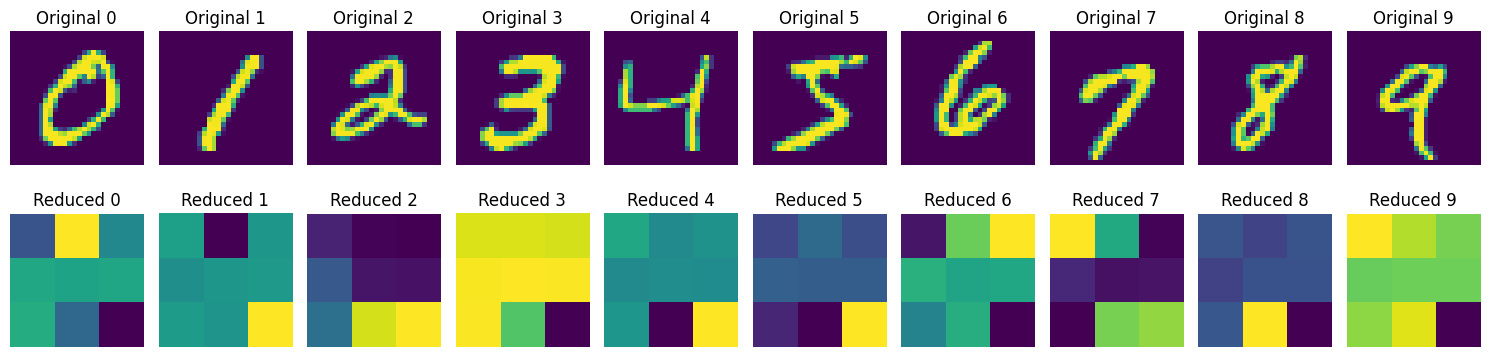

In [100]:
# class means and scatter matrices
num_class = 10
num_feats = nX.shape[1]
sw = np.zeros((num_feats, num_feats))
sb = np.zeros((num_feats, num_feats))
overall_mean = np.mean(nX, axis=0)

for i in range(num_class):
    class_i = nX[y == i]
    mean_i = np.mean(class_i, axis=0)

    sw += np.dot((class_i - mean_i).T, (class_i - mean_i))

    n_i = class_i.shape[0]
    mean_diff = (mean_i - overall_mean).reshape(num_feats, 1)
    sb += n_i * np.dot(mean_diff, mean_diff.T)

# compute projection matrix W
eigvals, eigvecs = np.linalg.eig(np.dot(np.linalg.pinv(sw), sb))
W = eigvecs[:, np.argsort(-eigvals.real)[:9]].real

# project the dataset to 9 dimensions
fX = np.dot(nX, W)

# display original and reduced images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for digit in range(10):
    # sample from each class
    original_image = X[y == digit][0].reshape(28, 28)
    reduced_image = fX[y == digit][0].reshape(3, 3)

    # original image
    axes[0, digit].imshow(original_image)
    axes[0, digit].axis('off')
    axes[0, digit].set_title(f"Original {digit}")

    # reduced image
    axes[1, digit].imshow(reduced_image)
    axes[1, digit].axis('off')
    axes[1, digit].set_title(f"Reduced {digit}")

plt.tight_layout()
plt.show()

# Task 1.2


Error for PCA on fX: 0.1188626758479625


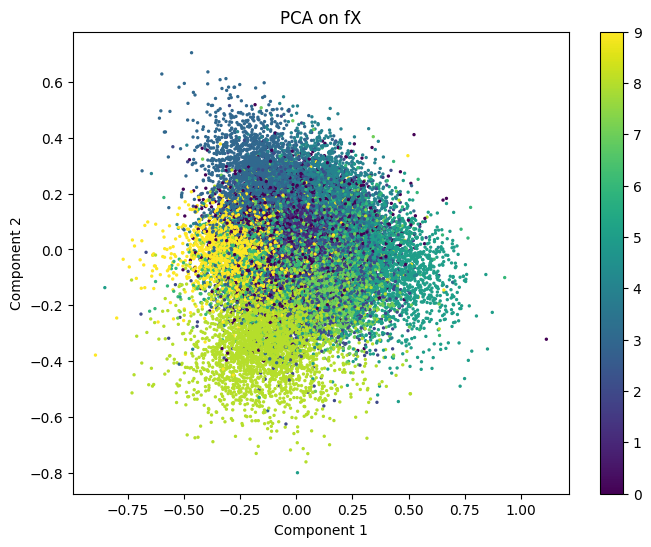

In [101]:
# PCA on fX
target_variance = 0.90
P, error_rate_fX = pca(fX, 2, target_variance)
p_reduced_fX = np.dot(fX, P)

print("Error for PCA on fX:", error_rate_fX)

# Visualize the reduced data if it is 2D
plt.figure(figsize=(8, 6))
plt.scatter(p_reduced_fX[:, 0], p_reduced_fX[:, 1], c=y, cmap='viridis', s=2)
plt.colorbar()
plt.title("PCA on fX")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

Error for PCA on nX: 0.9026316552841845


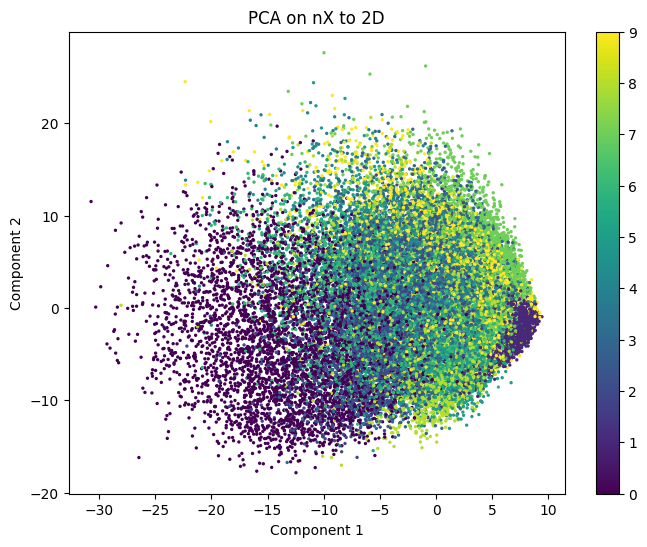

In [102]:
P, error_rate_nX = pca(nX, 2, .9)
p2nX = np.dot(nX, P)
print("Error for PCA on nX:", error_rate_nX)

# Visualize the 2D data
plt.figure(figsize=(8, 6))
plt.scatter(p2nX[:, 0], p2nX[:, 1], c=y, cmap='viridis', s=2)
plt.colorbar()
plt.title("PCA on nX to 2D")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [103]:
P, error_rate_pX = pca(nX, 0.9)  # 10% error rate implies 90% variance
pX = np.dot(nX, P)
print("Dimension for 10% Error Rate:", P.shape[1])

Dimension for 10% Error Rate: 235


# Task 1.3

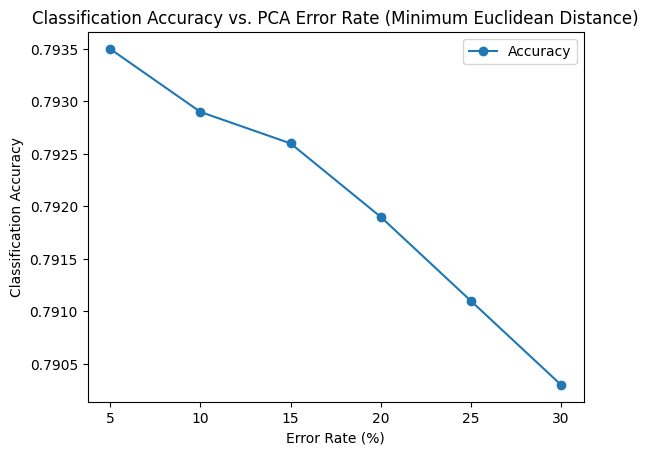

In [114]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# PCA function for dimensionality reduction
def pca(data, target_variance):
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    cov_matrix = np.cov(centered_data, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[sorted_indices], eigvecs[:, sorted_indices]

    total_variance = np.sum(eigvals)
    var_explained = np.cumsum(eigvals) / total_variance
    num_components = np.searchsorted(var_explained, target_variance) + 1
    P = eigvecs[:, :num_components]

    return P, mean

error_rates = np.arange(0.05, 0.35, 0.05)  # From 5% to 30% error rates
accuracy_results = []
train_times = []
test_times = []

for error_rate in error_rates:
    # Reduce dimensionality with PCA
    P, _ = pca(nX, 1 - error_rate)  # PCA projection matrix for target error rate
    pX = np.dot(nX, P)               # Projected data

    # Split data into train and test sets
    split_index = int(0.8 * len(pX))  # 80% train, 20% test
    X_train, X_test = pX[:split_index], pX[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Instantiate the minimum Euclidean distance classifier
    classifier = para(prior=[1 / len(np.unique(y))] * len(np.unique(y)))

    # Measure training time
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Measure testing time
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Calculate accuracy and times
    accuracy = accuracy_score(y_test, predictions)
    train_time = end_train - start_train
    test_time = end_test - start_test

    # Append results
    accuracy_results.append(accuracy)
    train_times.append(train_time)
    test_times.append(test_time)


plt.plot(error_rates * 100, accuracy_results, marker='o', label="Accuracy")
plt.xlabel("Error Rate (%)")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs. PCA Error Rate (Minimum Euclidean Distance)")
plt.legend()
plt.show()

In [115]:
results = []

# for timing and evaluating classifiers
def evaluate_classifier(clf, X_train, y_train, X_test, y_test, method_name, dataset_name):
    start_train = time.time()
    clf.fit(X_train, y_train)
    end_train = time.time()

    start_test = time.time()
    predictions = clf.predict(X_test)
    end_test = time.time()

    accuracy = accuracy_score(y_test, predictions)
    train_time = end_train - start_train
    test_time = end_test - start_test

    results.append({
        "Classifier": method_name,
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Train Time": train_time,
        "Test Time": test_time
    })

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Performance:
                  Classifier Dataset  Accuracy  Train Time  Test Time
0         Euclidean Distance      nX  0.751041    0.002257   7.768178
1         Euclidean Distance      fX  0.603000    0.000497   2.325720
2         Euclidean Distance      pX  0.747122    0.000718   2.415468
3                 kNN (k=15)      nX  0.775245   77.412685  77.412685
4                 kNN (k=15)      fX  0.757980    8.080855   8.080855
5                 kNN (k=15)      pX  0.825367   20.380047  20.380047
6  BPNN (3 layers, 15 nodes)      nX  0.844653    3.247113   0.149008
7  BPNN (3 layers, 15 nodes)      fX  0.697980    1.288092   0.062878
8  BPNN (3 layers, 15 nodes)      pX  0.823796    1.668166   0.045326


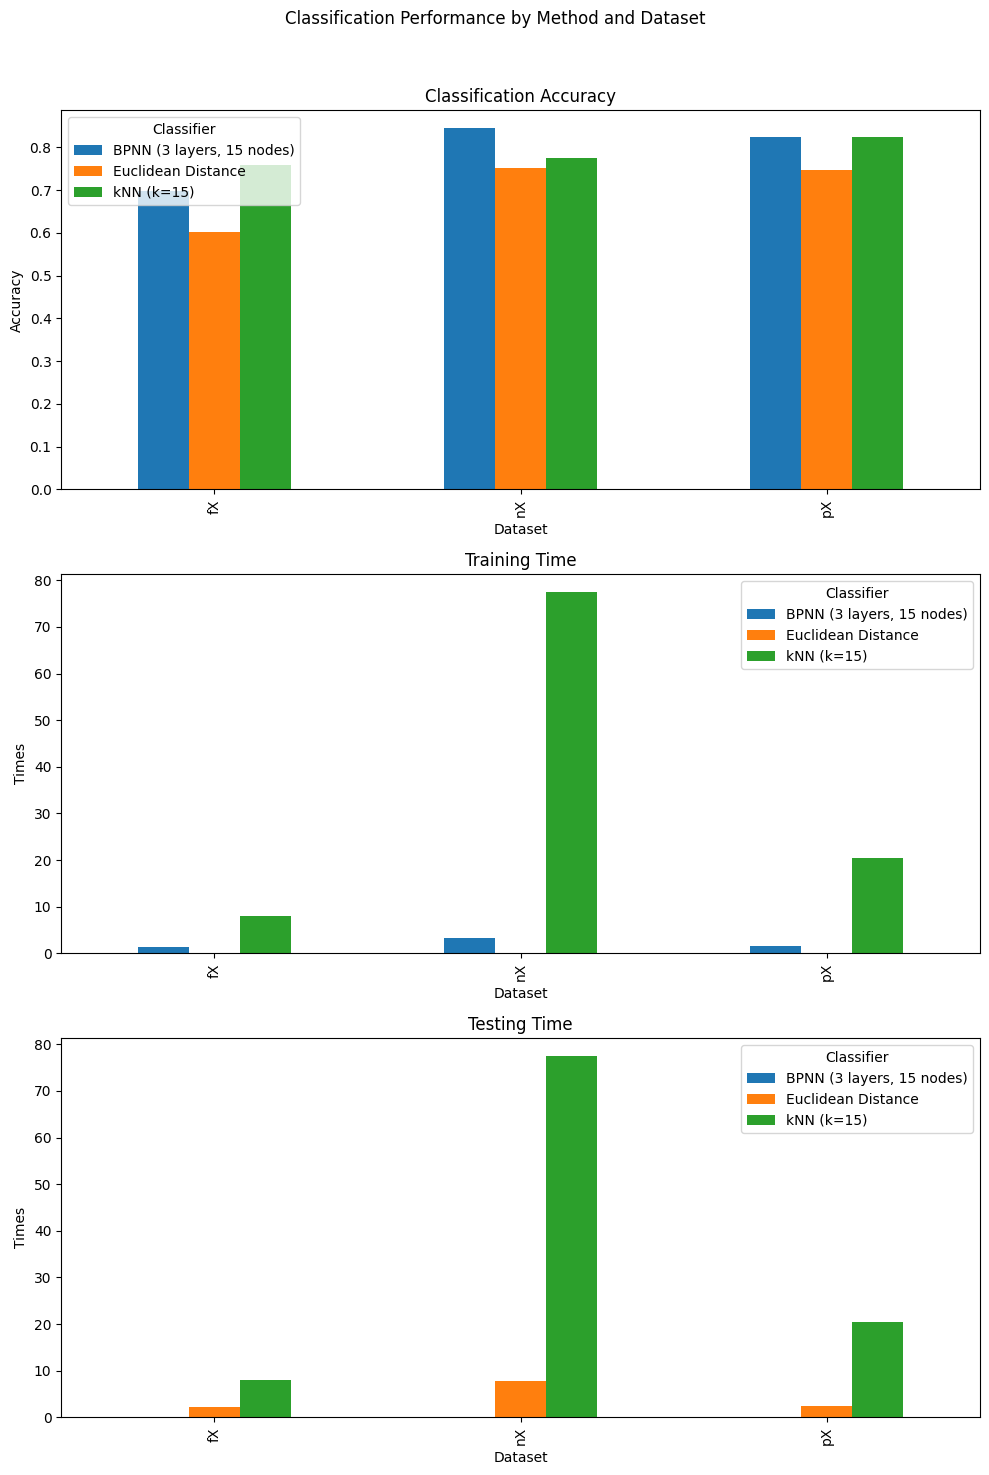

In [117]:
results = []
# Minimum Euclidean Distance Classifier
prior = [1 / len(np.unique(y))] * len(np.unique(y))
for dataset_name, X in zip(["nX", "fX", "pX"], [nX, fX, pX]):
    X_train, X_test = X[:10000], X[10000:]
    y_train, y_test = y[:10000], y[10000:]

    classifier = para(prior)
    evaluate_classifier(classifier, X_train, y_train, X_test, y_test, "Euclidean Distance", dataset_name)

# k-Nearest Neighbors (k=15)
k = 15
for dataset_name, X in zip(["nX", "fX", "pX"], [nX, fX, pX]):
    X_train, X_test = X[:10000], X[10000:]
    y_train, y_test = y[:10000], y[10000:]

    # training + testing time
    start_time = time.time()
    knn_classifier = nonpara(k)
    knn_classifier.fit(X_train, y_train)
    predictions = knn_classifier.predict(X_test)
    end_time = time.time()

    accuracy = accuracy_score(y_test, predictions)
    time_combined = end_time - start_time

    results.append({
        "Classifier": "kNN (k=15)",
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Train Time": time_combined,
        "Test Time": time_combined
    })

# BPNN
bpnn = MLPClassifier(hidden_layer_sizes=(15,), max_iter=300)
for dataset_name, X in zip(["nX", "fX", "pX"], [nX, fX, pX]):
    X_train, X_test = X[:10000], X[10000:]
    y_train, y_test = y[:10000], y[10000:]

    evaluate_classifier(bpnn, X_train, y_train, X_test, y_test, "BPNN (3 layers, 15 nodes)", dataset_name)


results_df = pd.DataFrame(results)
print("Classification Performance:")
print(results_df)

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle("Classification Performance by Method and Dataset")

results_df.pivot(index="Dataset", columns="Classifier", values="Accuracy").plot(kind="bar", ax=axes[0])
axes[0].set_title("Classification Accuracy")
axes[0].set_ylabel("Accuracy")
results_df.pivot(index="Dataset", columns="Classifier", values="Train Time").plot(kind="bar", ax=axes[1])
axes[1].set_title("Training Time")
axes[1].set_ylabel("Times")
results_df.pivot(index="Dataset", columns="Classifier", values="Test Time").plot(kind="bar", ax=axes[2])
axes[2].set_title("Testing Time")
axes[2].set_ylabel("Times")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# **Task 2**
# Task 2.1

In [118]:
# k-means
def kmeans(data, k, max_iters=100):

    centers = data[np.random.choice(data.shape[0], k, replace=False)].astype(np.float64)
    assignments = np.zeros(data.shape[0], dtype=int)

    for i in range(max_iters):
        distances = np.sqrt(((data[:, np.newaxis] - centers) ** 2).sum(axis=2))
        new_assignments = np.argmin(distances, axis=1)

        if np.array_equal(assignments, new_assignments):
            break

        assignments = new_assignments

        for j in range(k):
            if np.any(assignments == j):
                centers[j] = data[assignments == j].mean(axis=0)

    return centers, assignments

# Winner-Take-All
def wta(data, k, max_iters=100, initial_learning_rate=0.1):

    centers = data[np.random.choice(data.shape[0], k, replace=False)].astype(np.float64)
    assignments = np.zeros(data.shape[0], dtype=int)

    for epoch in range(max_iters):
        learning_rate = initial_learning_rate / (1 + epoch / max_iters)  # Decay learning rate

        for idx, point in enumerate(data):
            distances = np.linalg.norm(centers - point, axis=1)
            winner = np.argmin(distances)
            assignments[idx] = winner
            centers[winner] += learning_rate * (point - centers[winner])

    return centers, assignments

def calculate_rmse(original, compressed):
    return np.sqrt(mean_squared_error(original, compressed))

# original image in 3d RGB space
def plot_rgb_3d(data):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data / 255.0, marker='o')
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    plt.title("Original Image in 3D RGB")
    plt.show()

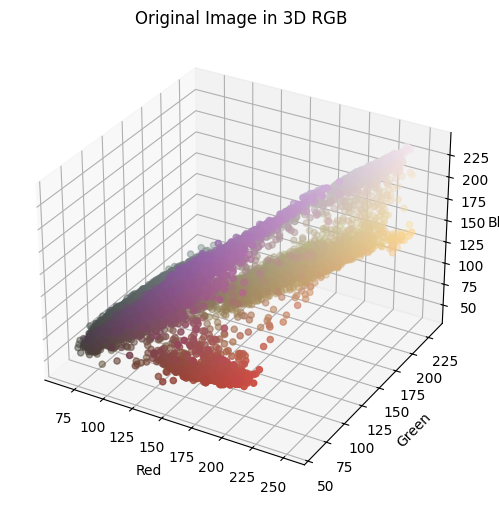

In [119]:
image = io.imread("flowersm.ppm")

data = image.reshape(-1, 3)

# plot in 3d
plot_rgb_3d(data)

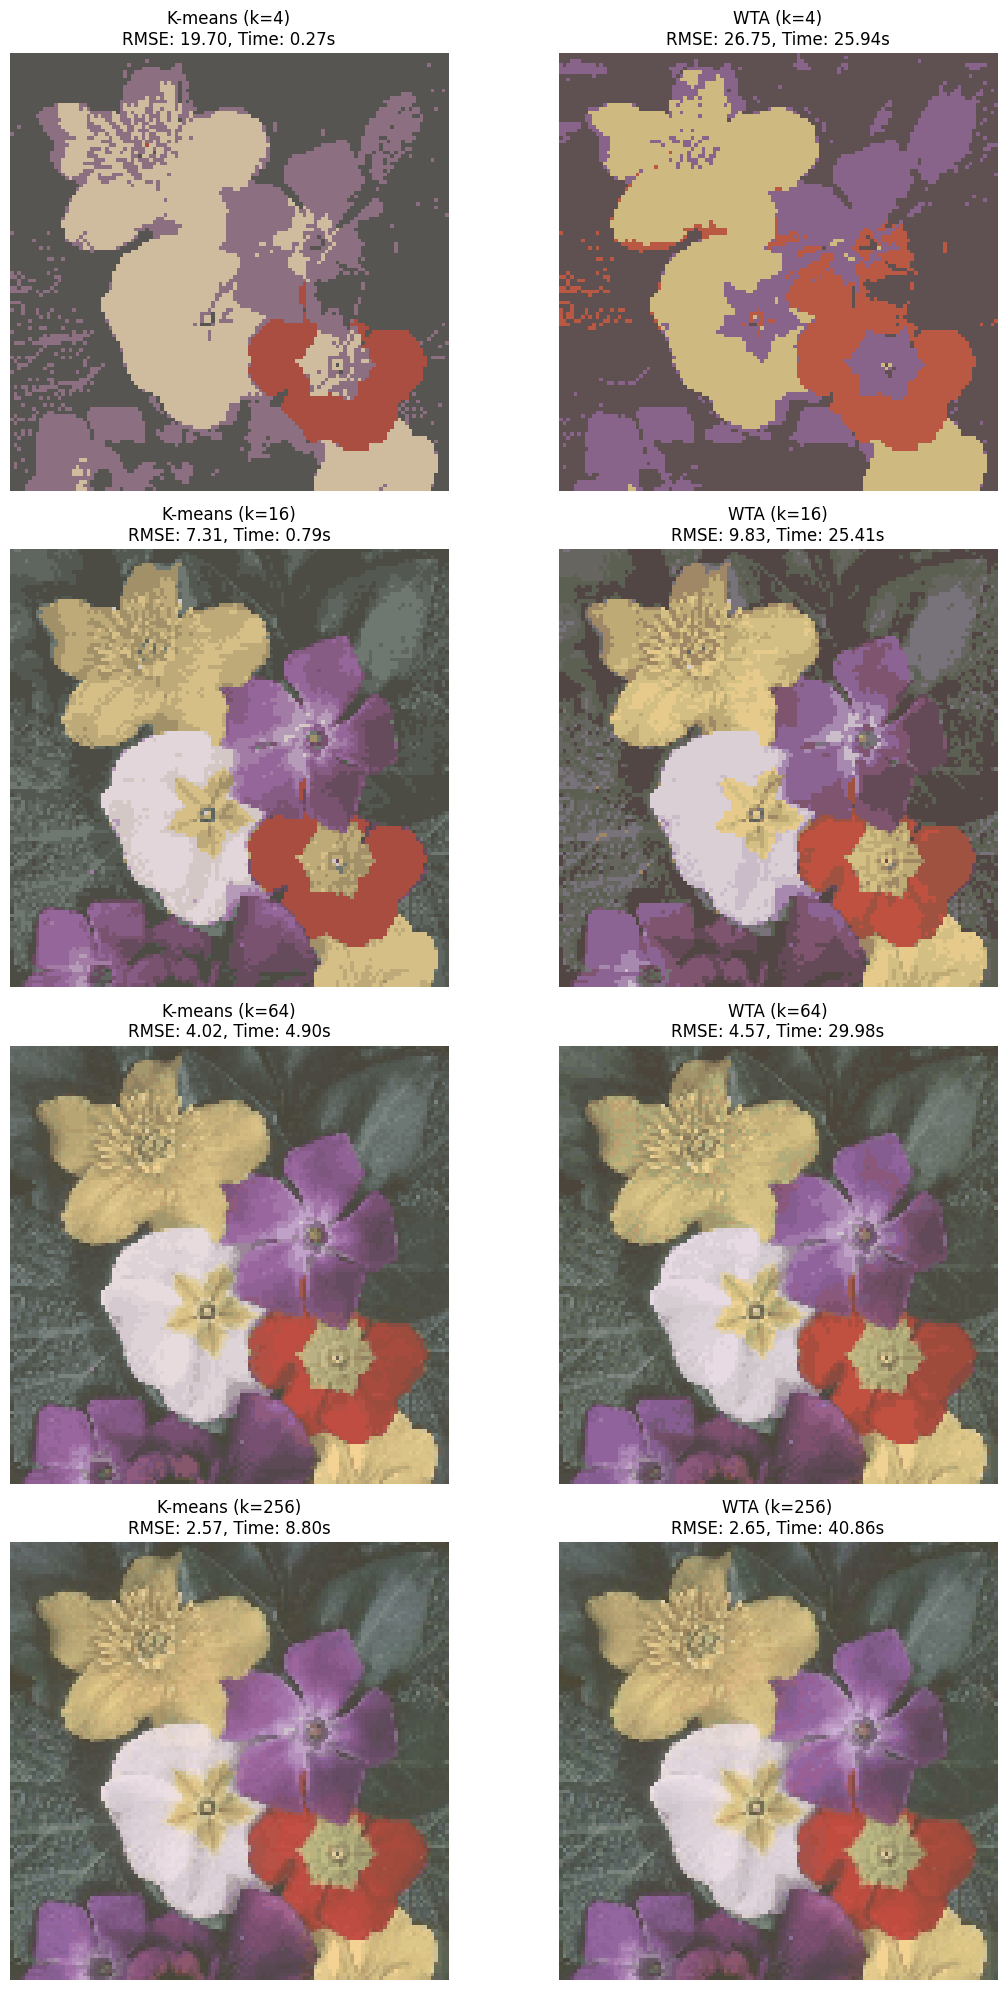

In [120]:
image_shape = image.shape
data = image.reshape(-1, 3)  # flatten again because it wouldnt work if i didn't do it again for some reason :/

# values of k to test
ks = [4, 16, 64, 256]
results = []

for k in ks:
    row = {'k': k}

    # K-means
    start = time.time()
    centers_kmeans, assignments_kmeans = kmeans(data, k)
    end = time.time()
    compressed_kmeans = centers_kmeans[assignments_kmeans].reshape(image_shape)  # Reshape back to image shape
    rmse_kmeans = calculate_rmse(data, compressed_kmeans.reshape(-1, 3))
    row['K-means'] = (compressed_kmeans, rmse_kmeans, end - start)

    # WTA
    start = time.time()
    centers_wta, assignments_wta = wta(data, k)
    end = time.time()
    compressed_wta = centers_wta[assignments_wta].reshape(image_shape)  # Reshape back to image shape
    rmse_wta = calculate_rmse(data, compressed_wta.reshape(-1, 3))
    row['WTA'] = (compressed_wta, rmse_wta, end - start)

    # add to results
    results.append(row)

fig, axes = plt.subplots(len(ks), 2, figsize=(12, 20))

for row_idx, k in enumerate(ks):

    # K-means
    kmeans_img, kmeans_rmse, kmeans_time = results[row_idx]['K-means']
    axes[row_idx, 0].imshow(kmeans_img.astype(np.uint8))
    axes[row_idx, 0].set_title(f'K-means (k={k})\nRMSE: {kmeans_rmse:.2f}, Time: {kmeans_time:.2f}s')
    axes[row_idx, 0].axis('off')

    # WTA
    wta_img, wta_rmse, wta_time = results[row_idx]['WTA']
    axes[row_idx, 1].imshow(wta_img.astype(np.uint8))
    axes[row_idx, 1].set_title(f'WTA (k={k})\nRMSE: {wta_rmse:.2f}, Time: {wta_time:.2f}s')
    axes[row_idx, 1].axis('off')

plt.tight_layout()
plt.show()

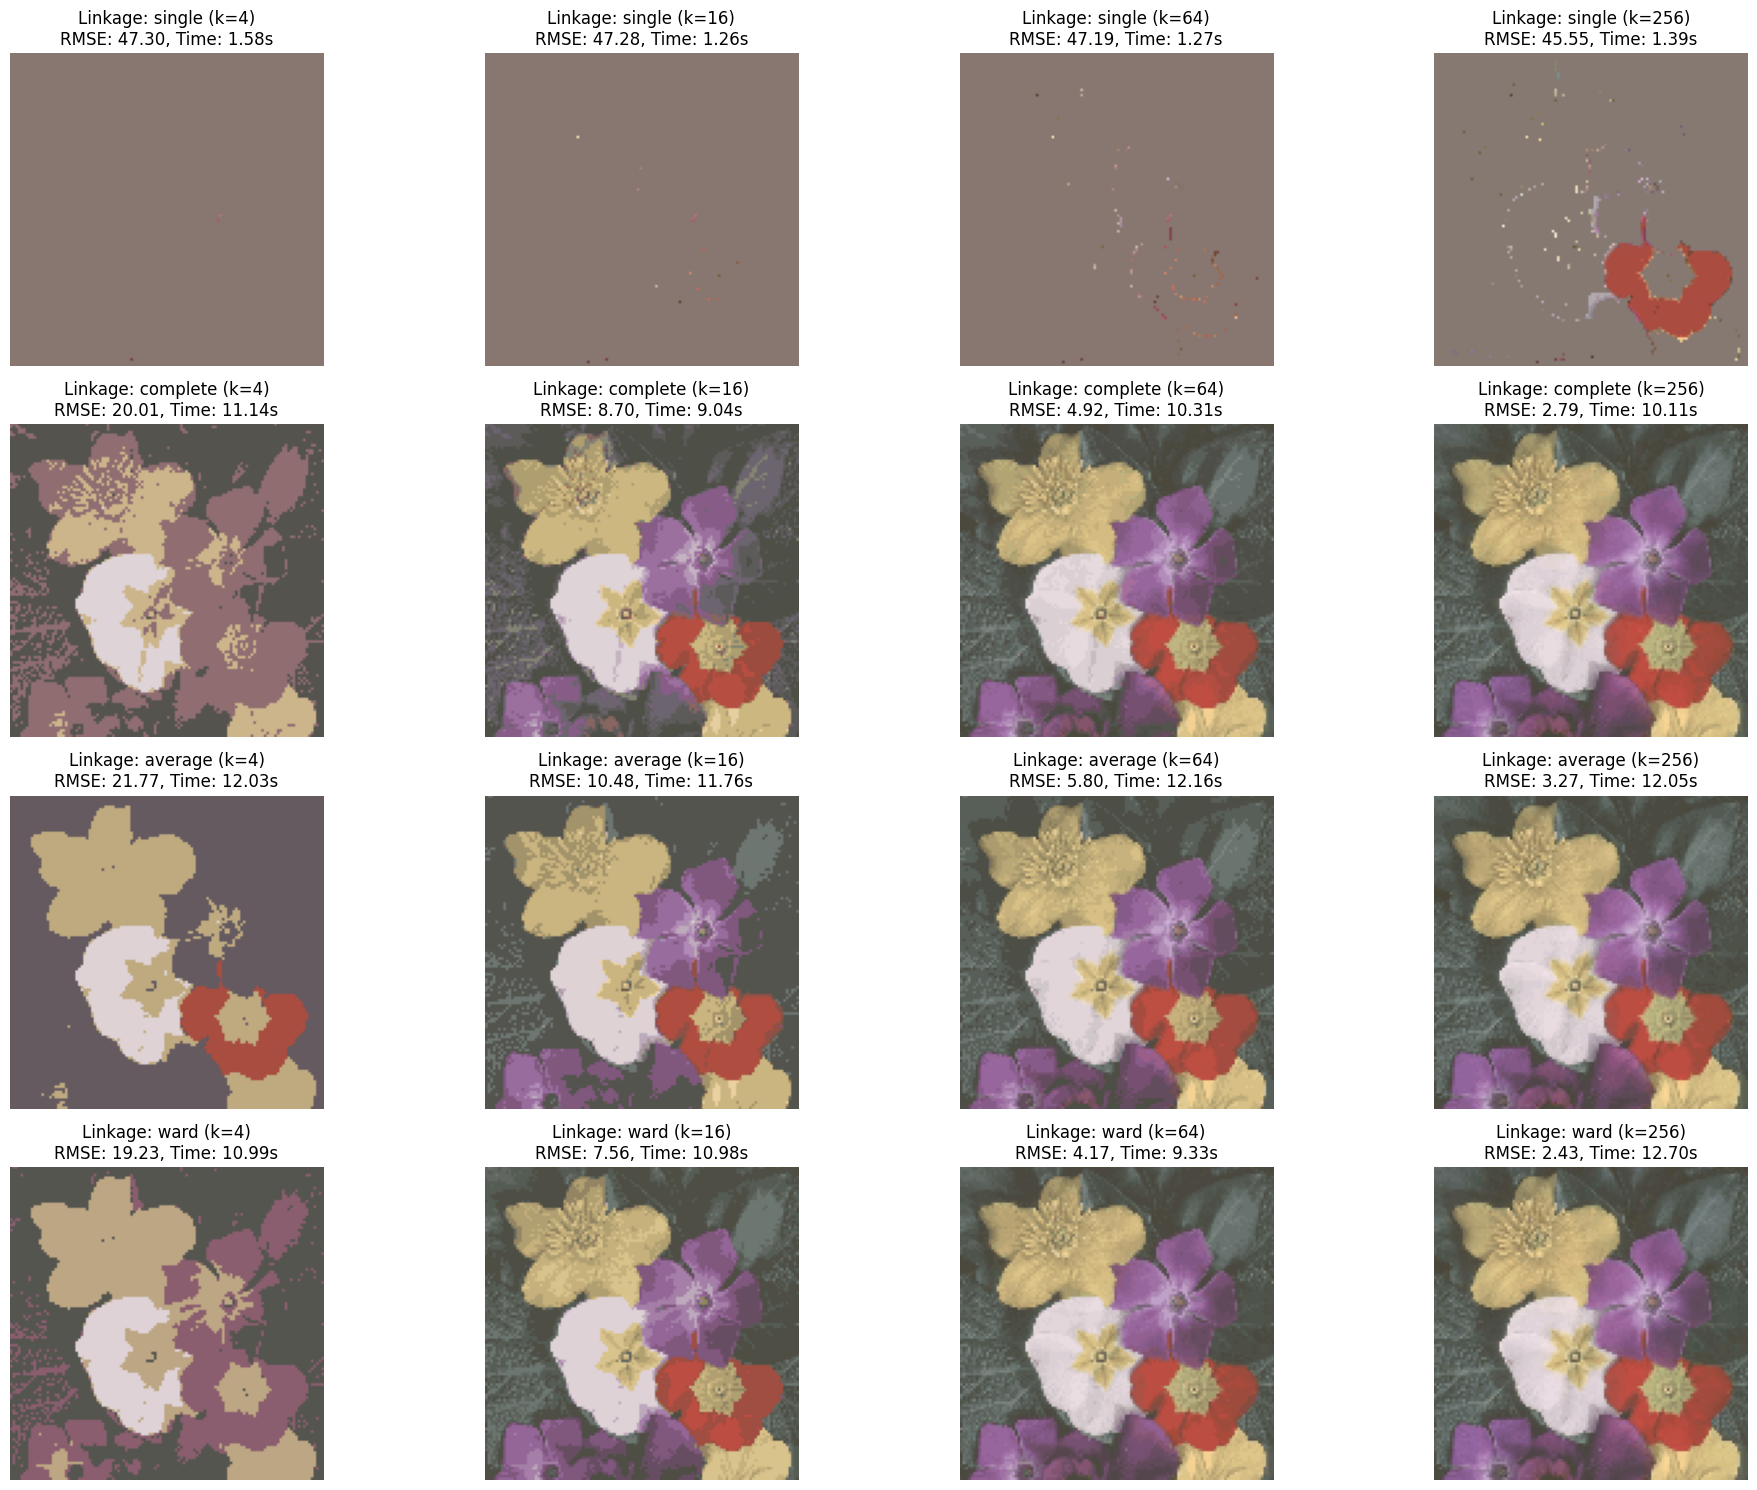

In [121]:
image_shape = image.shape
data = image.reshape(-1, 3)  # same annoying problem as before ^^

# different linkage methods to test
linkages = ['single', 'complete', 'average', 'ward']
results_hierarchical = []

for k in ks:
    for linkage in linkages:
        # agglomerative clustering
        start = time.time()
        hc = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        assignments_hc = hc.fit_predict(data)

        # cluster center
        centers_hc = np.array([data[assignments_hc == i].mean(axis=0) for i in range(k)])
        compressed_hc = centers_hc[assignments_hc].reshape(image_shape)  # Reshape back to image shape

        # RMSE and runtime
        rmse_hc = calculate_rmse(data, compressed_hc.reshape(-1, 3))
        end = time.time()
        # add to list
        results_hierarchical.append({
            'k': k,
            'Linkage': linkage,
            'Image': compressed_hc,
            'RMSE': rmse_hc,
            'Runtime': end - start
        })

fig, axes = plt.subplots(len(linkages), len(ks), figsize=(20, 15))

for col, k in enumerate(ks):
    for row, linkage in enumerate(linkages):
        result = next(r for r in results_hierarchical if r['k'] == k and r['Linkage'] == linkage)

        img, rmse, runtime = result['Image'], result['RMSE'], result['Runtime']
        axes[row, col].imshow(img.astype(np.uint8))
        axes[row, col].set_title(f'Linkage: {linkage} (k={k})\nRMSE: {rmse:.2f}, Time: {runtime:.2f}s')
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()